# Github - Track issues on Community Roaadmap
The objective of the notebook is to maintain a track of issues that are open in the community roadmap

Tags: #naas #github #issues


## Input

### Imports

In [16]:
import requests
import pandas as pd
from urllib.parse import urlencode
from datetime import datetime
import plotly.express as px

### Variables

In [3]:
project_url="https://api.github.com/orgs/jupyter-naas/projects"
token = "ghp_V8ynao6l98DQwtSbgLfSOgR***********"

## Model

### Get projects active on Github

In [4]:
def get_active_project_links(token, url):
    project_df = pd.DataFrame()
    headers={"Authorization":f'token {token}'}
    page=1
    while True:
        params = {
            "per_page":100,
            'page':page
        }
        url = url+ f"?{urlencode(params, safe='(),')}"
        res = requests.get(url, headers=headers, params=params)
        
        try:
            res.raise_for_status()   
        except requests.HTTPError as e:
            raise(e)
        if len(res.json())==0:
            break
        res_json = res.json()

        for idx, project in enumerate(res_json):
            project_df.loc[idx, 'project_name'] = project.get('name')
            project_df.loc[idx, 'project_description'] = project.get('body')
            project_df.loc[idx, 'project_id'] = project.get('number')
            project_df.loc[idx, 'project_created_by'] = project.get('creator')['login']
            
            project_df.loc[idx, 'project_created_date'] = project.get('created_at').strip('Z').split('T')[0]
            project_df.loc[idx, 'project_created_time'] = project.get('created_at').strip('Z').split('T')[-1]
            project_df.loc[idx, 'project_updated_date'] = project.get('updated_at').strip('Z').split('T')[0]
            project_df.loc[idx, 'project_updated_time'] = project.get('updated_at').strip('Z').split('T')[-1]
            
            project_df.loc[idx, 'project_columns_url'] = project.get('columns_url')
            
        page+=1
        
    project_df['project_id'] = project_df.project_id.apply(lambda x: int(x))
    return project_df

df_projects = get_active_project_links(token, project_url)

df_projects.head()

,project_name,project_description,project_id,project_created_by,project_created_date,project_created_time,project_updated_date,project_updated_time,project_columns_url
0,Community Roadmap,Official Naas Community Roadmap,4,jravenel,2021-05-25,20:53:14,2022-02-05,23:43:49,https://api.github.com/projects/12537896/columns


### Get comments from issues

In [12]:
def get_comments_from_issues(url):
    headers={"Authorization":f'token {token}'}
    issue_comments=[]
    comments = requests.get(url, headers=headers)
    try:
        comments.raise_for_status()
    except requests.HTTPError as e:
        raise(e)
    if len(comments.json())==0:
        return 'No comments'
    else:
        for comment in comments.json():
            issue_comments.append(comment['body'])
        return issue_comments

### Get details regarding issues from projects

In [32]:
def get_issues_from_projects(token, project_url):
    
    df_projects = get_active_project_links(token, project_url)
    df_issues = pd.DataFrame(columns=['issue_status', 'issue_state'])
    headers={"Authorization":f'token {token}'}
    
    ## Gets info from columns present in our roadmap ##
    for _, project in df_projects.iterrows():
        
        columns = requests.get(project['project_columns_url'], headers=headers).json()
        issue_status, issue_urls=[],[]
        for column in columns:
            page=1
            while True:
                params = {
                    'per_page':100,
                    'page':page
                }
                card_url = column['cards_url']+ f"?{urlencode(params, safe='(),')}"
                issues = requests.get(card_url, headers=headers)
                try:
                    issues.raise_for_status()
                except requests.HTTPError as e:
                    raise(e)
                if len(issues.json()) == 0:
                    break
                for issue in issues.json():
                    if issue.get('content_url')!=None:                        
                        issue_urls.append(issue.get('content_url'))
                        issue_status.append(column['name'])
                page+=1
                
        df_issues['issue_status'] = issue_status
        
        for idx, url in enumerate(issue_urls):
            issue = requests.get(url, headers=headers)
            try:
                issue.raise_for_status()
            except requests.HTTPError as e:
                raise(e)
            issue = issue.json()
            ###### information to be extracted are below #####
            df_issues.loc[idx, 'link_to_the_issue'], df_issues.loc[idx, 'issue_number'] = issue['html_url'], issue['number']
            df_issues.loc[idx, 'issue_title'], df_issues.loc[idx, 'issue_state'] = issue['title'], issue['state']

            labels= []
            for label in issue['labels']:
                labels.append(label.get('name'))
            df_issues.loc[idx, 'issue_labels'] = ", ".join(labels)

            assigned=[]
            for assignee in issue['assignees']:
                assigned.append(assignee.get('login'))
            if assigned==[]:
                df_issues.loc[idx, 'issue_assignees'] = 'None'
            else:
                df_issues.loc[idx, 'issue_assignees'] = ", ".join(assigned)

            df_issues.loc[idx, 'comments_till_date'] = issue['comments']

            df_issues.loc[idx, 'last_created_date'] = issue.get('created_at').strip('Z').split('T')[0]
            df_issues.loc[idx, 'last_created_time'] = issue.get('created_at').strip('Z').split('T')[-1]
            df_issues.loc[idx, 'last_updated_date'] = issue.get('updated_at').strip('Z').split('T')[0]
            df_issues.loc[idx, 'last_updated_time'] = issue.get('updated_at').strip('Z').split('T')[-1]

            if df_issues.loc[idx, 'issue_status']!='Backlog':
                date_format = "%Y-%m-%d"
                delta = datetime.now() - datetime.strptime(df_issues.loc[idx, 'last_updated_date'], date_format)
                df_issues.loc[idx, 'stale_issue'] = f'No activity since {delta.days} days'
            else:
                df_issues.loc[idx, 'stale_issue'] = 'None'
            
            df_issues.loc[idx, 'comments'] = str(get_comments_from_issues(issue['comments_url']))
            ##################################################
        
        df_issues['project_id'] = [df_projects.project_id.values[0]]*df_issues.shape[0]
        df_issues['project_name'] = [df_projects.project_name.values[0]]*df_issues.shape[0]
        df_issues['issue_number'] = df_issues['issue_number'].apply(lambda x: int(x))
        df_issues['comments_till_date'] = df_issues['comments_till_date'].apply(lambda x: int(x))
        
    return df_issues

df_issues = get_issues_from_projects(token, project_url)

## Output

In [33]:
df_issues.head()

,issue_status,issue_state,link_to_the_issue,issue_number,issue_title,issue_labels,issue_assignees,comments_till_date,last_created_date,last_created_time,last_updated_date,last_updated_time,stale_issue,comments,project_id,project_name
0,Backlog,open,https://github.com/jupyter-naas/awesome-notebo...,307,Get data from TikTok API,good first issue,"megha2907, calok64, RiddhiDeshpande222",0,2022-01-24,16:45:54,2022-01-25,04:21:40,None,No comments,4,Community Roadmap
1,Backlog,open,https://github.com/jupyter-naas/awesome-notebo...,281,Notion - Send Google Forms responses to Notion DB,good first issue,None,0,2021-12-14,13:58:47,2021-12-15,08:15:25,None,No comments,4,Community Roadmap
2,Backlog,open,https://github.com/jupyter-naas/awesome-notebo...,280,Notion - Create item in a Notion DB when new e...,good first issue,None,0,2021-12-14,13:25:18,2021-12-15,08:15:20,None,No comments,4,Community Roadmap
3,Backlog,open,https://github.com/jupyter-naas/awesome-notebo...,279,Notion - Create item in Notion DB with new for...,good first issue,None,0,2021-12-14,13:18:39,2021-12-15,08:15:13,None,No comments,4,Community Roadmap
4,Backlog,open,https://github.com/jupyter-naas/awesome-notebo...,278,Notion - Create item in Notion DB with new Git...,good first issue,None,0,2021-12-14,12:47:50,2021-12-15,08:15:08,None,No comments,4,Community Roadmap


### Plotting a bar graph for issues

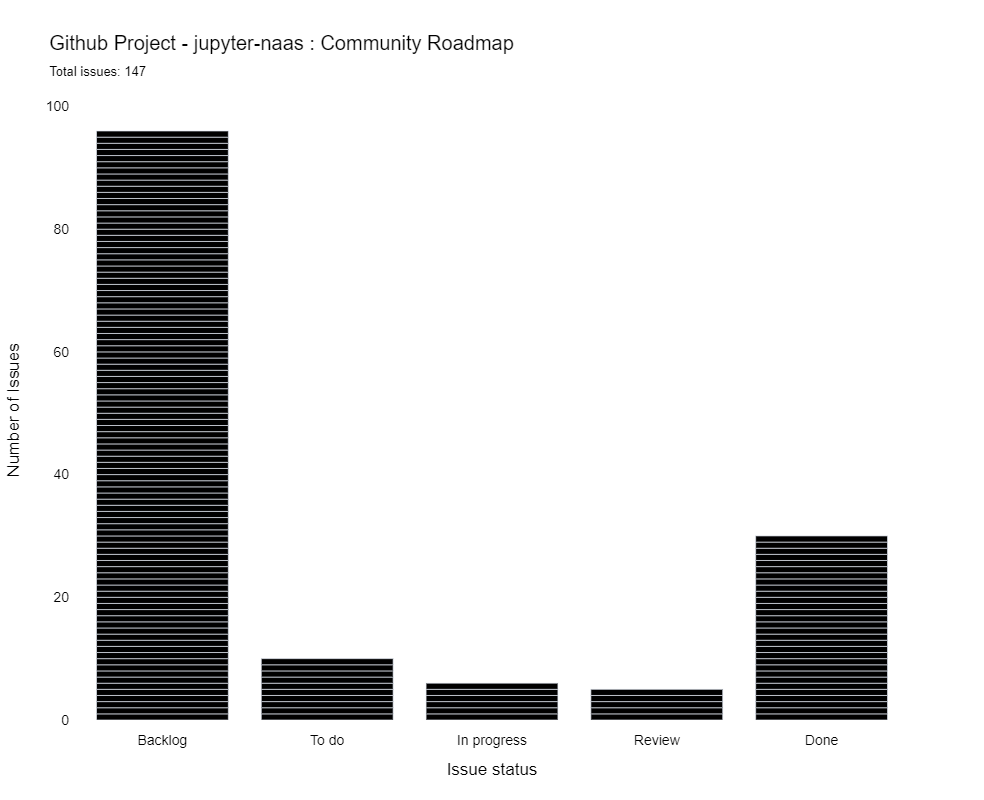

In [34]:
def create_barchart(df, project_url):
    df_issues['count']=1
    df_issues.groupby('issue_status')['count'].sum().reset_index()
    # Create fig
    fig = px.bar(df,
           title=f"Github Project - {project_url.split('/')[-2]} : {df_issues['project_name'].unique()[0]} <br><span style='font-size: 13px;'>Total issues: {df_issues.groupby('issue_status')['count'].sum().sum()}</span>",
           x="issue_status",
           y="count",
           labels={
               'issue_status':'Issue status',
               'count':"Number of Issues"
          })
    fig.update_traces(marker_color='black')
    fig.update_layout(
        plot_bgcolor="#ffffff",
        width=1000,
        height=800,
        font=dict(family="Arial", size=14, color="black"),
        paper_bgcolor="white",
        margin_pad=10,
    )
    fig.show()
    return fig

fig = create_barchart(df_issues, project_url)